In [ ]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, log_loss
from sklearn.preprocessing import PowerTransformer

c:\Users\Parthiban M\.conda\envs\gigloan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of samples
n = 5000

# ---------------------------
# 1. Basic Applicant Information
# ---------------------------
applicant_id = np.arange(1, n + 1)
age = np.random.randint(22, 60, n)
education_level = np.random.choice(
    ["High School", "Graduate", "Postgraduate"],
    n,
    p=[0.4, 0.45, 0.15]
)

# ---------------------------
# 2. Gig Work Details
# ---------------------------
# List of popular gig platforms in India
all_platforms = [
    "Swiggy", "Zomato", "Rapido", "Ola", "Uber",
    "Amazon Flex", "Dunzo", "UrbanClap", "Fiverr", "Upwork"
]

def pick_platforms():
    count = np.random.choice([1, 2, 3], p=[0.6, 0.3, 0.1])
    return random.sample(all_platforms, count)

gig_platforms_list = [pick_platforms() for _ in range(n)]
gig_platforms = [", ".join(platforms) for platforms in gig_platforms_list]
num_platforms = [len(platforms) for platforms in gig_platforms_list]
work_experience = np.random.randint(0, 15, n)  # in years

# ---------------------------
# 3. Financial Information with Seasonal Effects
# ---------------------------
# Base monthly income using a normal distribution (in INR)
base_income = np.random.normal(loc=30000, scale=10000, size=n).astype(int)
base_income = np.clip(base_income, 5000, 100000)

# Seasonal variation factor: simulate peaks (range from 0.8 to 1.5)
seasonal_variation = np.random.choice(np.linspace(0.8, 1.5, 15), n)

# Adjust monthly income for multi-platform engagement (10% boost per extra platform)
monthly_income = (base_income * seasonal_variation * (1 + 0.1 * (np.array(num_platforms) - 1))).astype(int)

# Income volatility: proportional to income (5% to 30% variability)
income_volatility = (monthly_income * np.random.uniform(0.05, 0.3, n)).astype(int)

# Savings balance: roughly 6 months of income times a factor between 0.2 and 0.5
savings_balance = (monthly_income * 6 * np.random.uniform(0.2, 0.5, n)).astype(int)
savings_balance = np.clip(savings_balance, 0, 500000)

# Simulate existing loans realistically
existing_loans = np.random.choice([0, 1, 2, 3], size=n, p=[0.7, 0.2, 0.08, 0.02])

# Calculate Debt-to-Income Ratio (DTI)
dti_base = np.random.uniform(0.1, 0.3, n)
debt_to_income_ratio = np.clip(dti_base * (1 + 0.2 * existing_loans), 0.1, 0.6)

# Loan amount requested (in INR) with microfinance focus: 70% micro (below 50k), 30% regular
micro_loans = np.random.randint(10000, 50000, int(n * 0.7))
regular_loans = np.random.randint(50000, 500000, n - int(n * 0.7))
loan_amount_requested = np.concatenate([micro_loans, regular_loans])
np.random.shuffle(loan_amount_requested)

# ---------------------------
# 4. Credit Score Calculation (CIBIL-like)
# ---------------------------
credit_score = (
    300 +
    (monthly_income / 100) -
    (debt_to_income_ratio * 50) +
    np.random.normal(0, 30, n)
)
credit_score = np.clip(credit_score, 300, 900).astype(int)

# ---------------------------
# 5. Behavioral and Economic Factors
# ---------------------------
transaction_frequency = np.random.randint(10, 100, n)
avg_monthly_expenses = np.random.randint(5000, 70000, n)
credit_card_utilization = np.random.randint(10, 90, n)
subscription_services = np.random.randint(0, 5, n)
financial_emergencies_last_year = np.random.randint(0, 5, n)
# Enhanced inflation rates (capped at 7.8% per RBI data)
inflation_rate = np.round(np.random.uniform(3, 7.8, n), 2)

# ---------------------------
# 6. Additional Untraditional Parameters
# ---------------------------
loan_reasons = [
    "Vehicle Purchase", "Medical Emergency", "Education", 
    "Home Renovation", "Debt Consolidation", "Business Expansion", "Other"
]
reason_for_loan = np.random.choice(loan_reasons, n)

def generate_platform_ratings(platforms):
    ratings = {p: round(np.random.uniform(3.0, 5.0), 1) for p in platforms}
    return "; ".join([f"{p}:{r}" for p, r in ratings.items()])

platform_ratings = [generate_platform_ratings(platforms) for platforms in gig_platforms_list]
customer_feedback_score = [
    round(np.mean([float(r.split(":")[1]) for r in ratings.split("; ")]) * 20 + np.random.uniform(-5, 5), 1)
    for ratings in platform_ratings
]
work_consistency = np.random.randint(1, 8, n)
penalties = [max(0, int(np.random.poisson(1) - (score / 100))) for score in customer_feedback_score]
alternative_income_source = np.random.choice(["Yes", "No"], n, p=[0.3, 0.7])
loan_coapplicant = np.random.choice(["Yes", "No"], n, p=[0.2, 0.8])

# ---------------------------
# 7. Enhanced Geographic and Additional Features
# ---------------------------
indian_states = [
    'Maharashtra', 'Karnataka', 'Delhi', 'Tamil Nadu', 'Uttar Pradesh',
    'Gujarat', 'West Bengal', 'Telangana', 'Rajasthan', 'Bihar'
]
location = np.random.choice(indian_states, n, p=[0.18, 0.15, 0.12, 0.1, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05])
urban_ratio = 0.35
urban_rural = np.random.choice(['Urban', 'Rural'], n, p=[urban_ratio, 1 - urban_ratio])

def generate_platform_tenure(platforms):
    return [random.randint(3, 60) for _ in platforms]

platform_tenures = [generate_platform_tenure(platforms) for platforms in gig_platforms_list]
avg_platform_tenure = [np.mean(tenures) for tenures in platform_tenures]

family_dependents = poisson.rvs(mu=1.5, size=n)
family_dependents = np.clip(family_dependents, 0, 5)

cost_of_living_index = {
    'Maharashtra': 1.15, 'Karnataka': 1.1, 'Delhi': 1.25,
    'Tamil Nadu': 1.05, 'Uttar Pradesh': 0.95, 'Gujarat': 1.0,
    'West Bengal': 0.9, 'Telangana': 1.07, 'Rajasthan': 0.93, 'Bihar': 0.85
}
cost_of_living = np.array([cost_of_living_index[state] for state in location])

# ---------------------------
# 8. Loan Approval Outcome with Logical Checks
# ---------------------------
def determine_loan_approval(i):
    # Basic financial criteria
    crit_credit = credit_score[i] > 650
    crit_dti = debt_to_income_ratio[i] < 0.4
    crit_savings = savings_balance[i] > (loan_amount_requested[i] * 0.2)
    crit_feedback = customer_feedback_score[i] > 70
    crit_consistency = work_consistency[i] >= 3

    # Logical checks:
    crit_min_credit = credit_score[i] >= 500  # Very low credit scores should be rejected

    # If no co-applicant, require a higher credit score
    if loan_coapplicant[i] == "No":
        crit_coapplicant = credit_score[i] > 700
    else:
        crit_coapplicant = True

    # Combine all criteria
    if all([crit_credit, crit_dti, crit_savings, crit_feedback, crit_consistency, 
            crit_min_credit, crit_coapplicant]):
        return 1
    else:
        return 0

loan_approved = [determine_loan_approval(i) for i in range(n)]

# ---------------------------
# 9. Create Final DataFrame and Introduce Missing Values
# ---------------------------
df = pd.DataFrame({
    "applicant_id": applicant_id,
    "age": age,
    "education_level": education_level,
    "gig_platforms": gig_platforms,
    "num_platforms": num_platforms,
    "work_experience": work_experience,
    "monthly_income": monthly_income,
    "seasonal_variation": seasonal_variation,
    "income_volatility": income_volatility,
    "savings_balance": savings_balance,
    "debt_to_income_ratio": debt_to_income_ratio,
    "credit_score": credit_score,
    "existing_loans": existing_loans,
    "loan_amount_requested": loan_amount_requested,
    "transaction_frequency": transaction_frequency,
    "avg_monthly_expenses": avg_monthly_expenses,
    "credit_card_utilization": credit_card_utilization,
    "subscription_services": subscription_services,
    "financial_emergencies_last_year": financial_emergencies_last_year,
    "inflation_rate": inflation_rate,
    "reason_for_loan": reason_for_loan,
    "platform_ratings": platform_ratings,
    "customer_feedback_score": customer_feedback_score,
    "work_consistency": work_consistency,
    "penalties": penalties,
    "alternative_income_source": alternative_income_source,
    "loan_coapplicant": loan_coapplicant,
    "location": location,
    "urban_rural": urban_rural,
    "avg_platform_tenure": avg_platform_tenure,
    "family_dependents": family_dependents,
    "cost_of_living_index": cost_of_living,
    "loan_approved": loan_approved
})

# ---------------------------
# 10. Introduce Missing Values (Enhanced Pattern)
# ---------------------------
missing_config = {
    'education_level': 0.08,
    'work_experience': 0.08,
    'monthly_income': 0.12,
    'savings_balance': 0.12,
    'credit_score': 0.12,
    'avg_monthly_expenses': 0.12,
    'urban_rural': 0.05,
    'family_dependents': 0.03
}

for col, ratio in missing_config.items():
    df.loc[df.sample(frac=ratio).index, col] = np.nan

# ---------------------------
# 11. Validation Checks (Sanity Checks)
# ---------------------------
# 1. Inflation rate sanity check (should not exceed 7.8%)
assert df.inflation_rate.max() <= 7.8, "Inflation rate exceeds RBI cap."

# 2. Micro-loans proportion: ~70% loans should be under ₹50k
micro_proportion = (df.loan_amount_requested < 50000).mean()
assert 0.65 <= micro_proportion <= 0.75, "Micro-loan proportion out of range."

# 3. Regional cost of living: sample check for Delhi (if any records exist)
if (df.location == 'Delhi').any():
    delhi_cost = df[df.location == 'Delhi'].cost_of_living_index.mean()
    assert 1.2 < delhi_cost < 1.3, "Delhi cost of living anomaly."

# ---------------------------
# 12. Save Final Enhanced Dataset
# ---------------------------
df.to_csv("C:/test/gig_loan_approval_predictor/artifacts/data/indian_gig_loan_data.csv", index=False)


In [3]:
train, test = train_test_split(df, test_size=0.2, stratify=df['loan_approved'], random_state=42)
train.to_csv("C:/test/gig_loan_approval_predictor/artifacts/data/train.csv", index=False)
test.to_csv("C:/test/gig_loan_approval_predictor/artifacts/data/test.csv", index=False)

In [4]:
df.head()

,applicant_id,age,education_level,gig_platforms,num_platforms,work_experience,monthly_income,seasonal_variation,income_volatility,savings_balance,...,work_consistency,penalties,alternative_income_source,loan_coapplicant,location,urban_rural,avg_platform_tenure,family_dependents,cost_of_living_index,loan_approved
0,1,50,High School,"Zomato, Swiggy",2,14.0,53723.0,1.30,12075,106805.0,...,1,0,Yes,Yes,Karnataka,Urban,35.500000,1.0,1.1,0
1,2,36,Graduate,"Uber, Ola",2,11.0,36259.0,1.15,8656,76825.0,...,1,0,No,Yes,Gujarat,Rural,46.000000,3.0,1.0,0
2,3,29,Graduate,"Ola, Rapido",2,NaN,36798.0,1.35,8808,105922.0,...,7,2,No,No,Gujarat,Urban,28.000000,0.0,1.0,0
3,4,42,Graduate,Zomato,1,11.0,27033.0,1.20,1760,50845.0,...,2,0,Yes,No,West Bengal,Rural,57.000000,1.0,0.9,0
4,5,40,Postgraduate,"Fiverr, Zomato, Dunzo",3,8.0,14328.0,0.80,1444,18275.0,...,4,0,No,No,Gujarat,Urban,29.666667,2.0,1.0,0


In [5]:
df.shape

(5000, 33)

In [6]:
df.describe()

,applicant_id,age,num_platforms,work_experience,monthly_income,seasonal_variation,income_volatility,savings_balance,debt_to_income_ratio,credit_score,...,subscription_services,financial_emergencies_last_year,inflation_rate,customer_feedback_score,work_consistency,penalties,avg_platform_tenure,family_dependents,cost_of_living_index,loan_approved
count,5000.000000,5000.000000,5000.000000,4600.000000,4400.000000,5000.000000,5000.000000,4400.000000,5000.000000,4400.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4850.000000,5000.000000,5000.000000
mean,2500.500000,40.699800,1.497200,6.969565,36701.744545,1.157580,6374.438600,77156.281364,0.216723,652.151591,...,1.982800,1.990000,5.414488,79.873580,3.981000,0.354400,31.273733,1.467629,1.058946,0.209000
std,1443.520003,10.927249,0.671478,4.332248,14443.952351,0.214175,3775.962813,36744.147451,0.069575,136.297576,...,1.425381,1.426852,1.377970,10.789644,2.021746,0.709437,14.926367,1.200417,0.113780,0.406635
min,1.000000,22.000000,1.000000,0.000000,4000.000000,0.800000,279.000000,6331.000000,0.100123,300.000000,...,0.000000,0.000000,3.000000,55.000000,1.000000,0.000000,3.000000,0.000000,0.850000,0.000000
25%,1250.750000,31.000000,1.000000,3.000000,26367.750000,0.987500,3435.500000,50313.000000,0.159444,552.000000,...,1.000000,1.000000,4.230000,71.600000,2.000000,0.000000,19.000000,1.000000,0.950000,0.000000
50%,2500.500000,41.000000,1.000000,7.000000,35396.000000,1.150000,5650.500000,70802.000000,0.213854,644.500000,...,2.000000,2.000000,5.400000,79.800000,4.000000,0.000000,31.000000,1.000000,1.070000,0.000000
75%,3750.250000,50.000000,2.000000,11.000000,45838.500000,1.350000,8626.000000,98869.250000,0.267085,754.000000,...,3.000000,3.000000,6.600000,88.200000,6.000000,1.000000,43.000000,2.000000,1.150000,0.000000
max,5000.000000,59.000000,3.000000,14.000000,105599.000000,1.500000,26489.000000,260260.000000,0.476004,900.000000,...,4.000000,4.000000,7.800000,104.800000,7.000000,5.000000,60.000000,5.000000,1.250000,1.000000


In [7]:
df.columns

Index(['applicant_id', 'age', 'education_level', 'gig_platforms',
       'num_platforms', 'work_experience', 'monthly_income',
       'seasonal_variation', 'income_volatility', 'savings_balance',
       'debt_to_income_ratio', 'credit_score', 'existing_loans',
       'loan_amount_requested', 'transaction_frequency',
       'avg_monthly_expenses', 'credit_card_utilization',
       'subscription_services', 'financial_emergencies_last_year',
       'inflation_rate', 'reason_for_loan', 'platform_ratings',
       'customer_feedback_score', 'work_consistency', 'penalties',
       'alternative_income_source', 'loan_coapplicant', 'location',
       'urban_rural', 'avg_platform_tenure', 'family_dependents',
       'cost_of_living_index', 'loan_approved'],
      dtype='object')

In [8]:
df.isnull().sum()

applicant_id                         0
age                                  0
education_level                    400
gig_platforms                        0
num_platforms                        0
work_experience                    400
monthly_income                     600
seasonal_variation                   0
income_volatility                    0
savings_balance                    600
debt_to_income_ratio                 0
credit_score                       600
existing_loans                       0
loan_amount_requested                0
transaction_frequency                0
avg_monthly_expenses               600
credit_card_utilization              0
subscription_services                0
financial_emergencies_last_year      0
inflation_rate                       0
reason_for_loan                      0
platform_ratings                     0
customer_feedback_score              0
work_consistency                     0
penalties                            0
alternative_income_source

In [9]:
df.loc[(df['work_experience'] == 0) & (df['monthly_income'].isnull()), 'loan_approved'] = 0
# Create a fraud flag column
df['fraud_flag'] = ((df['work_experience'] == 0) & (df['monthly_income'].isnull())).astype(int)
#those who have work experience and monthly income as 0 are frauds

In [10]:
# Split the data into fraud and non-fraud
non_fraud_data = df[df['fraud_flag'] == 0]
fraud_data = df[df['fraud_flag'] == 1]

In [11]:
# Fill missing values as 0 in monthly_income the fraud data
fraud_data['monthly_income'] = fraud_data['monthly_income'].fillna(0)

C:\Users\Parthiban M\AppData\Local\Temp\ipykernel_14224\647293634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_data['monthly_income'] = fraud_data['monthly_income'].fillna(0)


In [12]:
# Fill missing values with median in the non-fraud data
non_fraud_data['monthly_income'].fillna(non_fraud_data['monthly_income'].median(), inplace=True)
non_fraud_data['work_experience'].fillna(non_fraud_data['work_experience'].median(), inplace=True)
non_fraud_data[non_fraud_data['work_experience']==0].fillna(non_fraud_data['work_experience'].median(), inplace=True)

C:\Users\Parthiban M\AppData\Local\Temp\ipykernel_14224\882540375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_fraud_data['monthly_income'].fillna(non_fraud_data['monthly_income'].median(), inplace=True)
C:\Users\Parthiban M\AppData\Local\Temp\ipykernel_14224\882540375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_fraud_data['work_experience'].fillna(non_fraud_data['work_experience'].median(), inplace=True)
C:\Users\Parthiban M\AppData\Local\Temp\ipykernel_14224\882540375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [13]:
df=pd.concat([non_fraud_data,fraud_data],ignore_index=True)

In [14]:

# Create a flag for first-time applicants (no work experience, no existing loans)
df['first_time_applicant'] = ((df['work_experience'] == 0) & (df['existing_loans'] == 0)).astype(int)

In [15]:
# Set credit score to -1 for first-time applicants
df.loc[df['first_time_applicant'] == 1, 'credit_score'] = -1

In [16]:
# Fill missing values in the savings _balence, avg_monthly_expenses and credit_score with the median
df['savings_balance'].fillna(df['savings_balance'].median(), inplace=True)
df['avg_monthly_expenses'].fillna(df['avg_monthly_expenses'].median(), inplace=True)
df['credit_score'].fillna(df['credit_score'].median(), inplace=True)

In [17]:
# Fill missing values in the urban_rural, family_dependents and education_level columns with the mode
df['urban_rural'].fillna(df['urban_rural'].mode()[0], inplace=True)
df['family_dependents'].fillna(df['family_dependents'].mode()[0], inplace=True)
df['education_level'].fillna(df['education_level'].mode()[0], inplace=True)

In [18]:
df.isnull().sum()

applicant_id                       0
age                                0
education_level                    0
gig_platforms                      0
num_platforms                      0
work_experience                    0
monthly_income                     0
seasonal_variation                 0
income_volatility                  0
savings_balance                    0
debt_to_income_ratio               0
credit_score                       0
existing_loans                     0
loan_amount_requested              0
transaction_frequency              0
avg_monthly_expenses               0
credit_card_utilization            0
subscription_services              0
financial_emergencies_last_year    0
inflation_rate                     0
reason_for_loan                    0
platform_ratings                   0
customer_feedback_score            0
work_consistency                   0
penalties                          0
alternative_income_source          0
loan_coapplicant                   0
l

In [19]:
df.dtypes

applicant_id                         int32
age                                  int32
education_level                     object
gig_platforms                       object
num_platforms                        int64
work_experience                    float64
monthly_income                     float64
seasonal_variation                 float64
income_volatility                    int32
savings_balance                    float64
debt_to_income_ratio               float64
credit_score                       float64
existing_loans                       int32
loan_amount_requested                int32
transaction_frequency                int32
avg_monthly_expenses               float64
credit_card_utilization              int32
subscription_services                int32
financial_emergencies_last_year      int32
inflation_rate                     float64
reason_for_loan                     object
platform_ratings                    object
customer_feedback_score            float64
work_consis

In [20]:
# Split the string into key-value pairs
platform_ratings = df['platform_ratings'].str.split('; ', expand=True)

# Convert to a dictionary using `str.split`
platform_ratings_dict = platform_ratings.applymap(lambda x: dict([x.split(':')]) if pd.notna(x) else {})

In [21]:
platform_ratings

,0,1,2
0,Zomato:4.7,Swiggy:3.3,None
1,Uber:3.4,Ola:3.4,None
2,Ola:3.5,Rapido:3.0,None
3,Zomato:3.8,None,None
4,Fiverr:5.0,Zomato:3.9,Dunzo:4.6
...,...,...,...
4995,Zomato:3.3,Fiverr:4.4,Amazon Flex:3.4
4996,Fiverr:4.4,None,None
4997,Upwork:4.4,None,None
4998,UrbanClap:3.3,None,None


In [22]:
platform_ratings_dict

,0,1,2
0,{'Zomato': '4.7'},{'Swiggy': '3.3'},{}
1,{'Uber': '3.4'},{'Ola': '3.4'},{}
2,{'Ola': '3.5'},{'Rapido': '3.0'},{}
3,{'Zomato': '3.8'},{},{}
4,{'Fiverr': '5.0'},{'Zomato': '3.9'},{'Dunzo': '4.6'}
...,...,...,...
4995,{'Zomato': '3.3'},{'Fiverr': '4.4'},{'Amazon Flex': '3.4'}
4996,{'Fiverr': '4.4'},{},{}
4997,{'Upwork': '4.4'},{},{}
4998,{'UrbanClap': '3.3'},{},{}


In [23]:
# Function to calculate the average of dictionary values
def calculate_avg(ratings):
    if isinstance(ratings, dict) and len(ratings) > 0:
        return sum(map(float, ratings.values())) / len(ratings)
    return None

# Create a new column with the average rating
platform_ratings_dict['avg_platform_rating'] = platform_ratings_dict[[0,1,2]].applymap(calculate_avg).mean(axis=1)

In [24]:
platform_ratings_dict.drop([0,1,2], axis=1, inplace=True)
platform_ratings_dict

,avg_platform_rating
0,4.00
1,3.40
2,3.25
3,3.80
4,4.50
...,...
4995,3.70
4996,4.40
4997,4.40
4998,3.30


In [25]:
pd.concat([df, platform_ratings_dict], axis=1)

,applicant_id,age,education_level,gig_platforms,num_platforms,work_experience,monthly_income,seasonal_variation,income_volatility,savings_balance,...,loan_coapplicant,location,urban_rural,avg_platform_tenure,family_dependents,cost_of_living_index,loan_approved,fraud_flag,first_time_applicant,avg_platform_rating
0,1,50,High School,"Zomato, Swiggy",2,14.0,53723.0,1.30,12075,106805.0,...,Yes,Karnataka,Urban,35.500000,1.0,1.10,0,0,0,4.00
1,2,36,Graduate,"Uber, Ola",2,11.0,36259.0,1.15,8656,76825.0,...,Yes,Gujarat,Rural,46.000000,3.0,1.00,0,0,0,3.40
2,3,29,Graduate,"Ola, Rapido",2,7.0,36798.0,1.35,8808,105922.0,...,No,Gujarat,Urban,28.000000,0.0,1.00,0,0,0,3.25
3,4,42,Graduate,Zomato,1,11.0,27033.0,1.20,1760,50845.0,...,No,West Bengal,Rural,57.000000,1.0,0.90,0,0,0,3.80
4,5,40,Postgraduate,"Fiverr, Zomato, Dunzo",3,8.0,14328.0,0.80,1444,18275.0,...,No,Gujarat,Urban,29.666667,2.0,1.00,0,0,0,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4778,52,High School,"Zomato, Fiverr, Amazon Flex",3,0.0,0.0,1.05,5644,97204.0,...,No,West Bengal,Rural,33.000000,0.0,0.90,0,1,1,3.70
4996,4781,32,Postgraduate,Fiverr,1,0.0,0.0,0.85,8005,46181.0,...,Yes,West Bengal,Urban,44.000000,0.0,0.90,0,1,0,4.40
4997,4806,53,High School,Upwork,1,0.0,0.0,1.20,3315,49397.0,...,No,Telangana,Rural,21.000000,1.0,1.07,0,1,1,4.40
4998,4869,59,Graduate,UrbanClap,1,0.0,0.0,1.15,4612,70378.0,...,No,Uttar Pradesh,Rural,48.000000,2.0,0.95,0,1,0,3.30


In [26]:
df.to_csv("C:/test/gig_loan_approval_predictor/artifacts/data/gig_loan_processed_analysis.csv", index=False)

In [27]:
df.drop(columns=['first_time_applicant','fraud_flag','applicant_id','gig_platforms','platform_ratings','location'],inplace=True,axis=1)

In [28]:
df.columns

Index(['age', 'education_level', 'num_platforms', 'work_experience',
       'monthly_income', 'seasonal_variation', 'income_volatility',
       'savings_balance', 'debt_to_income_ratio', 'credit_score',
       'existing_loans', 'loan_amount_requested', 'transaction_frequency',
       'avg_monthly_expenses', 'credit_card_utilization',
       'subscription_services', 'financial_emergencies_last_year',
       'inflation_rate', 'reason_for_loan', 'customer_feedback_score',
       'work_consistency', 'penalties', 'alternative_income_source',
       'loan_coapplicant', 'urban_rural', 'avg_platform_tenure',
       'family_dependents', 'cost_of_living_index', 'loan_approved'],
      dtype='object')

In [29]:
df.dtypes

age                                  int32
education_level                     object
num_platforms                        int64
work_experience                    float64
monthly_income                     float64
seasonal_variation                 float64
income_volatility                    int32
savings_balance                    float64
debt_to_income_ratio               float64
credit_score                       float64
existing_loans                       int32
loan_amount_requested                int32
transaction_frequency                int32
avg_monthly_expenses               float64
credit_card_utilization              int32
subscription_services                int32
financial_emergencies_last_year      int32
inflation_rate                     float64
reason_for_loan                     object
customer_feedback_score            float64
work_consistency                     int32
penalties                            int64
alternative_income_source           object
loan_coappl

In [30]:
#label encoding for the categorical columns
df['education_level'] = df['education_level'].map({'High School': 0, 'Graduate': 1, 'Postgraduate': 2})
df['urban_rural'] = df['urban_rural'].map({'Urban': 1, 'Rural': 0})
df['alternative_income_source'] = df['alternative_income_source'].map({'Yes': 1, 'No': 0})
df['loan_coapplicant'] = df['loan_coapplicant'].map({'Yes': 1, 'No': 0})

In [31]:
df['education_level']=df['education_level'].astype('int')
df['alternative_income_source']=df['alternative_income_source'].astype('int')
df['loan_coapplicant']=df['loan_coapplicant'].astype('int')
df['urban_rural']=df['urban_rural'].astype('int')
df['family_dependents']=df['family_dependents'].astype('int')

In [32]:
# one hot encoding 
df = pd.get_dummies(df, columns=['reason_for_loan'], drop_first=True)

In [33]:
df

,age,education_level,num_platforms,work_experience,monthly_income,seasonal_variation,income_volatility,savings_balance,debt_to_income_ratio,credit_score,...,avg_platform_tenure,family_dependents,cost_of_living_index,loan_approved,reason_for_loan_Debt Consolidation,reason_for_loan_Education,reason_for_loan_Home Renovation,reason_for_loan_Medical Emergency,reason_for_loan_Other,reason_for_loan_Vehicle Purchase
0,50,0,2,14.0,53723.0,1.30,12075,106805.0,0.304228,786.0,...,35.500000,1,1.10,0,False,True,False,False,False,False
1,36,1,2,11.0,36259.0,1.15,8656,76825.0,0.135687,696.0,...,46.000000,3,1.00,0,False,False,False,False,True,False
2,29,1,2,7.0,36798.0,1.35,8808,105922.0,0.110491,636.0,...,28.000000,0,1.00,0,False,False,False,False,False,True
3,42,1,1,11.0,27033.0,1.20,1760,50845.0,0.398722,592.0,...,57.000000,1,0.90,0,False,True,False,False,False,False
4,40,2,3,8.0,14328.0,0.80,1444,18275.0,0.361707,400.0,...,29.666667,2,1.00,0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,52,0,3,0.0,0.0,1.05,5644,97204.0,0.244277,-1.0,...,33.000000,0,0.90,0,False,True,False,False,False,False
4996,32,2,1,0.0,0.0,0.85,8005,46181.0,0.251739,659.0,...,44.000000,0,0.90,0,False,False,False,False,True,False
4997,53,0,1,0.0,0.0,1.20,3315,49397.0,0.118155,-1.0,...,21.000000,1,1.07,0,False,False,False,False,True,False
4998,59,1,1,0.0,0.0,1.15,4612,70378.0,0.389317,749.0,...,48.000000,2,0.95,0,True,False,False,False,False,False


In [34]:
df.dtypes

age                                     int32
education_level                         int32
num_platforms                           int64
work_experience                       float64
monthly_income                        float64
seasonal_variation                    float64
income_volatility                       int32
savings_balance                       float64
debt_to_income_ratio                  float64
credit_score                          float64
existing_loans                          int32
loan_amount_requested                   int32
transaction_frequency                   int32
avg_monthly_expenses                  float64
credit_card_utilization                 int32
subscription_services                   int32
financial_emergencies_last_year         int32
inflation_rate                        float64
customer_feedback_score               float64
work_consistency                        int32
penalties                               int64
alternative_income_source         

In [35]:
df.corr()

,age,education_level,num_platforms,work_experience,monthly_income,seasonal_variation,income_volatility,savings_balance,debt_to_income_ratio,credit_score,...,avg_platform_tenure,family_dependents,cost_of_living_index,loan_approved,reason_for_loan_Debt Consolidation,reason_for_loan_Education,reason_for_loan_Home Renovation,reason_for_loan_Medical Emergency,reason_for_loan_Other,reason_for_loan_Vehicle Purchase
age,1.000000,0.022624,0.001153,0.024023,-0.012720,0.008631,-0.004730,0.002019,-0.005610,-0.004692,...,-0.026159,0.010750,0.008107,-0.011471,-0.011878,0.004219,0.020217,-0.026787,-0.000376,0.003145
education_level,0.022624,1.000000,-0.014072,0.000588,-0.001748,-0.029673,0.007508,0.020187,0.012914,-0.005478,...,0.020113,-0.041611,-0.011143,-0.002471,-0.009587,0.015403,-0.002952,0.006691,-0.020660,0.002120
num_platforms,0.001153,-0.014072,1.000000,0.009005,0.144831,-0.016822,0.098213,0.145943,0.005644,0.101997,...,0.010555,0.000842,0.003352,0.116051,0.002997,-0.010533,0.007633,0.024223,-0.004171,-0.035279
work_experience,0.024023,0.000588,0.009005,1.000000,0.044800,-0.009921,0.006517,-0.010868,0.006741,0.275821,...,-0.006633,0.003352,0.001380,0.016985,0.011753,-0.005687,0.007832,0.009971,-0.017634,-0.014786
monthly_income,-0.012720,-0.001748,0.144831,0.044800,1.000000,0.424807,0.609994,0.709383,0.012420,0.601892,...,-0.001371,-0.006516,0.010621,0.478223,-0.013914,0.002959,0.002032,-0.013509,0.011685,0.003615
seasonal_variation,0.008631,-0.029673,-0.016822,-0.009921,0.424807,1.000000,0.310687,0.362898,0.011383,0.286345,...,0.003895,-0.015876,-0.002701,0.258069,0.008104,0.017590,0.002864,-0.010121,-0.026018,0.009052
income_volatility,-0.004730,0.007508,0.098213,0.006517,0.609994,0.310687,1.000000,0.520742,0.004616,0.401451,...,0.011434,-0.013004,0.000337,0.329571,-0.006592,0.023264,-0.015416,-0.008417,0.016246,-0.002296
savings_balance,0.002019,0.020187,0.145943,-0.010868,0.709383,0.362898,0.520742,1.000000,-0.006525,0.474474,...,0.001714,-0.020245,0.006109,0.408460,-0.005094,0.000243,0.005144,0.002422,0.009296,-0.015095
debt_to_income_ratio,-0.005610,0.012914,0.005644,0.006741,0.012420,0.011383,0.004616,-0.006525,1.000000,0.030206,...,-0.026978,-0.004188,0.004797,-0.006584,-0.027687,-0.003222,0.034287,0.016669,-0.020661,0.000621
credit_score,-0.004692,-0.005478,0.101997,0.275821,0.601892,0.286345,0.401451,0.474474,0.030206,1.000000,...,-0.008467,0.000287,0.012214,0.359874,-0.007360,-0.003100,0.001456,0.006407,-0.001045,0.003607


In [36]:
df.skew()

age                                  -0.027742
education_level                       0.317425
num_platforms                         1.005654
work_experience                       0.003265
monthly_income                        0.417724
seasonal_variation                   -0.035920
income_volatility                     0.948808
savings_balance                       1.011165
debt_to_income_ratio                  0.421589
credit_score                         -1.482016
existing_loans                        1.689105
loan_amount_requested                 1.645385
transaction_frequency                 0.044456
avg_monthly_expenses                 -0.009286
credit_card_utilization               0.029981
subscription_services                 0.008714
financial_emergencies_last_year       0.013870
inflation_rate                        0.004239
customer_feedback_score               0.016189
work_consistency                      0.015443
penalties                             2.385577
alternative_i

In [37]:
df['savings_balance'] = np.log1p(df['savings_balance'])
df['existing_loans'] = np.log1p(df['existing_loans'])
df['loan_amount_requested'] = np.log1p(df['loan_amount_requested'])
df['penalties'] = np.log1p(df['penalties'])
df['num_platforms'] = np.log1p(df['num_platforms'])
df['loan_coapplicant'] = np.log1p(df['loan_coapplicant'])

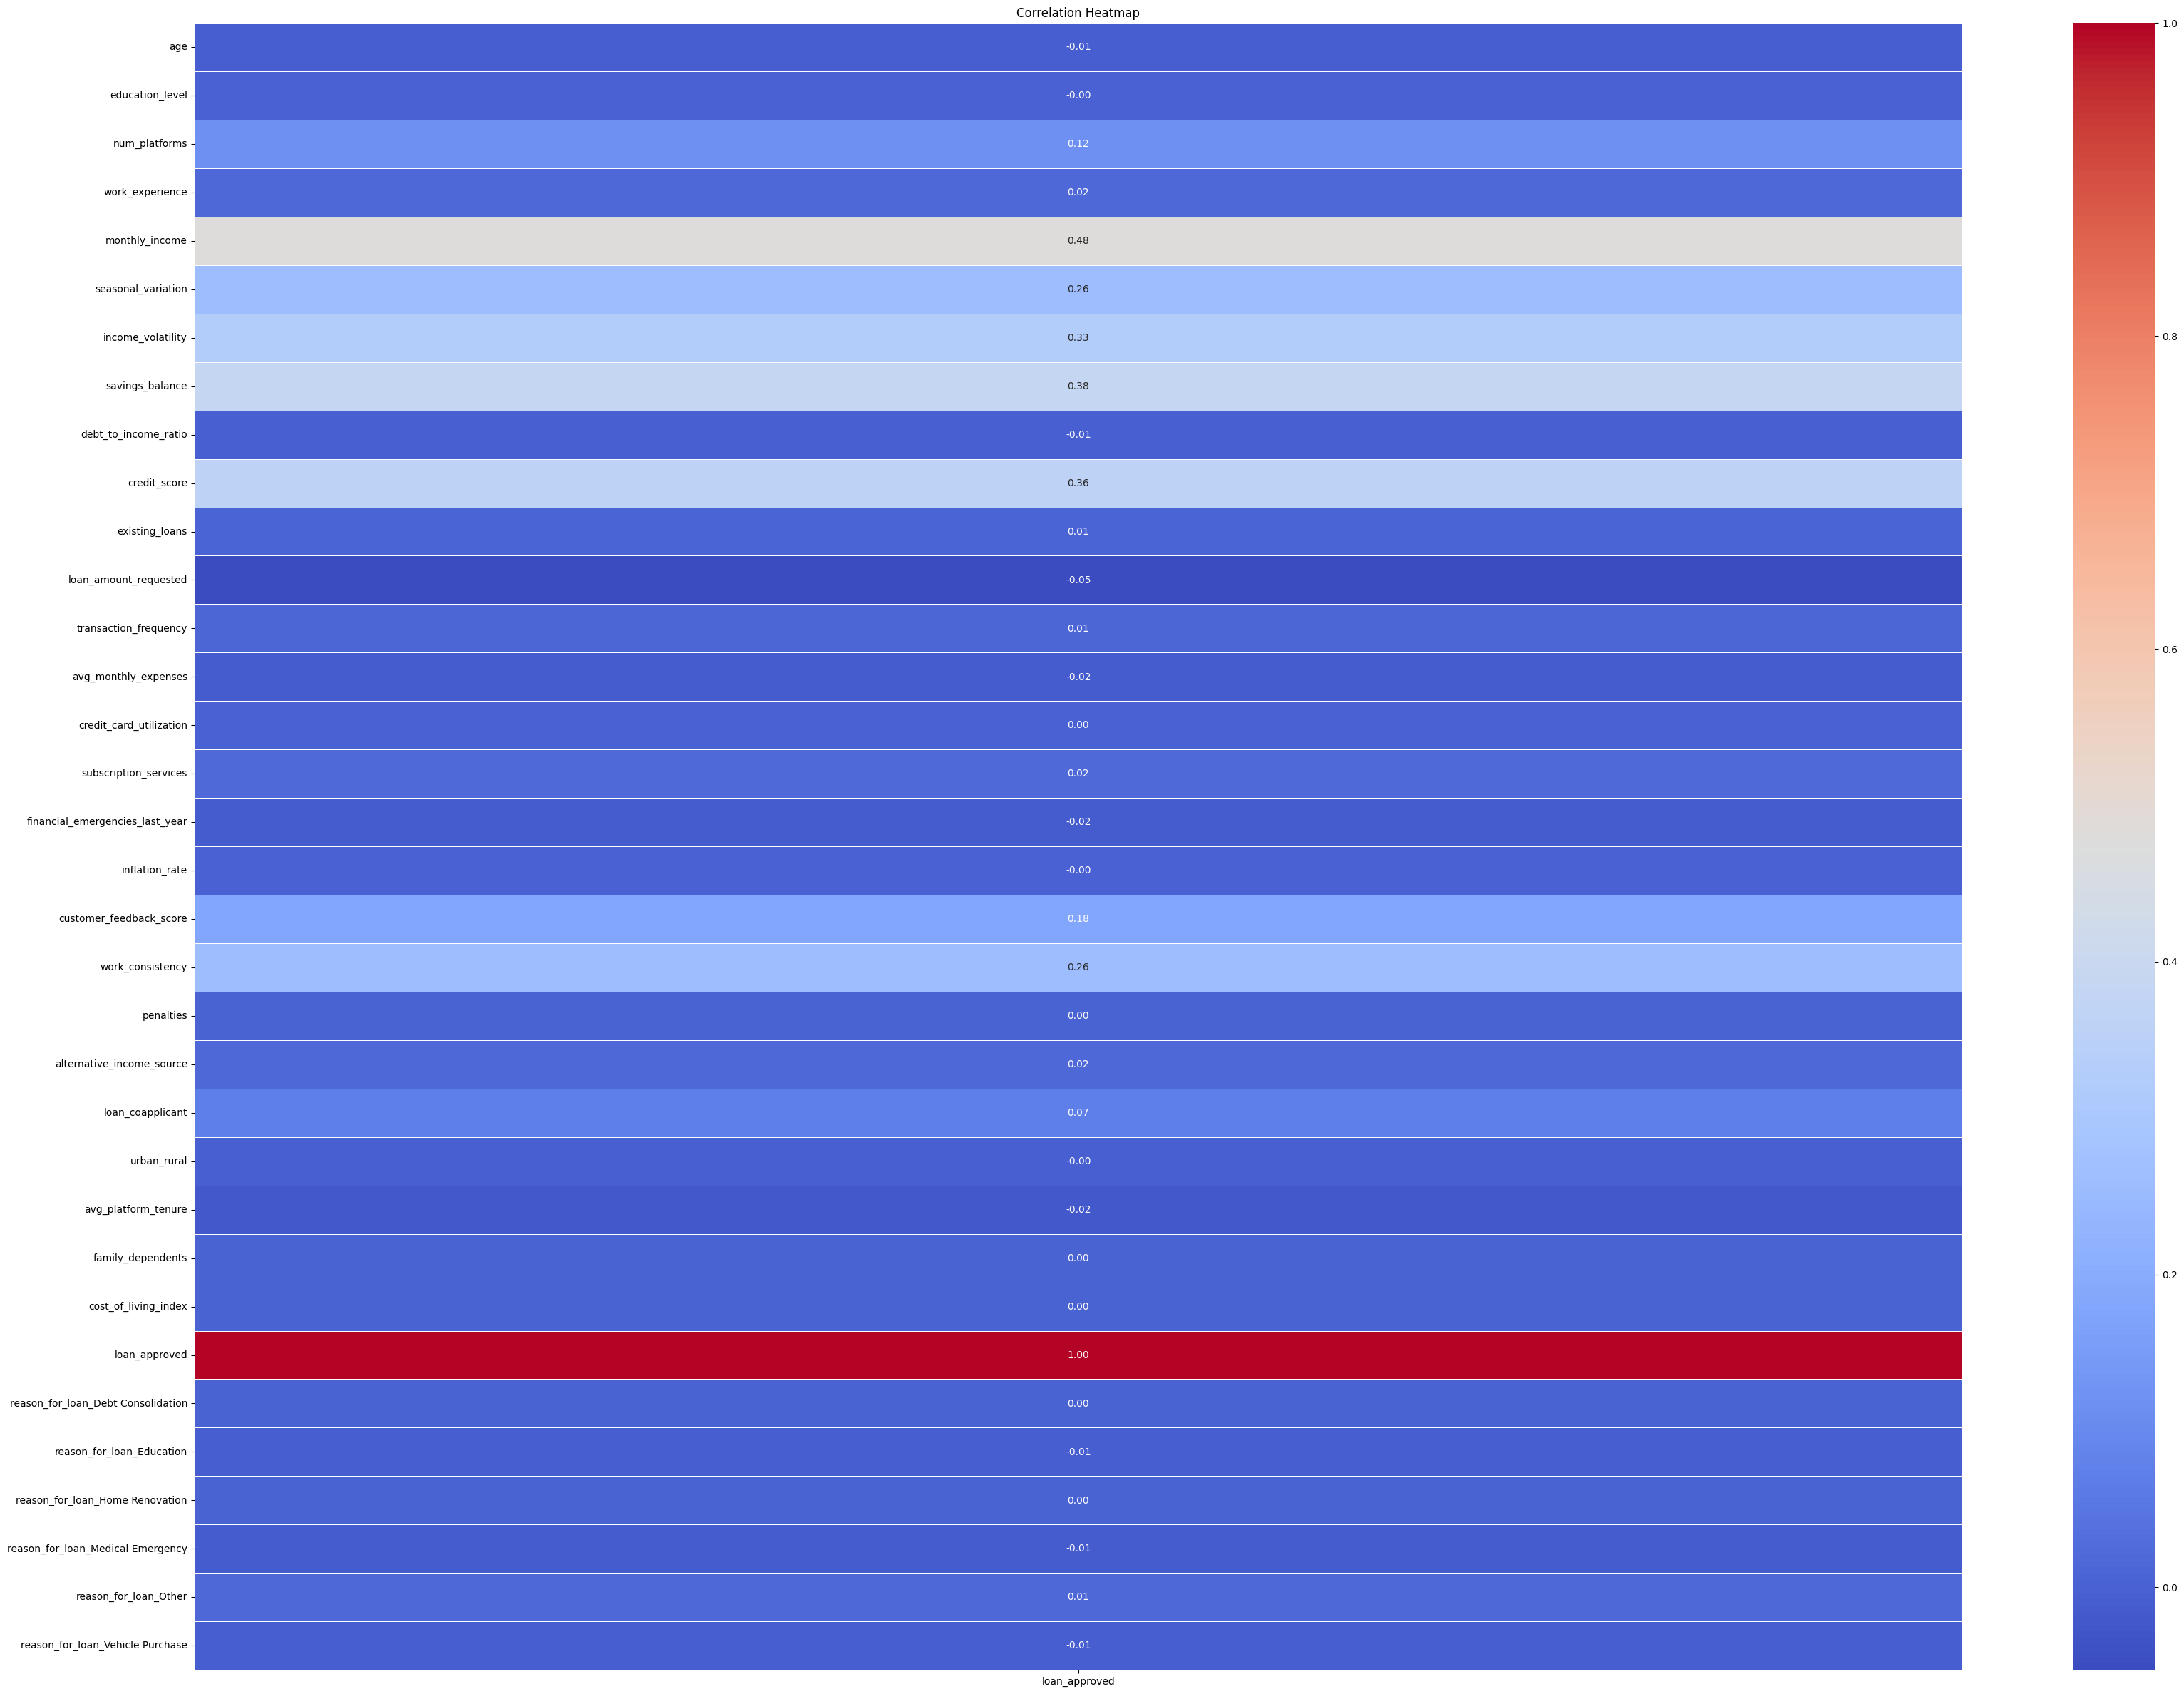

In [38]:
correlation=df.corr()['loan_approved'].to_frame()
plt.figure(figsize=(40, 30))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [39]:
correlation

,loan_approved
age,-0.011471
education_level,-0.002471
num_platforms,0.118082
work_experience,0.016985
monthly_income,0.478223
seasonal_variation,0.258069
income_volatility,0.329571
savings_balance,0.384364
debt_to_income_ratio,-0.006584
credit_score,0.359874


In [40]:
df.skew()

age                                  -0.027742
education_level                       0.317425
num_platforms                         0.774914
work_experience                       0.003265
monthly_income                        0.417724
seasonal_variation                   -0.035920
income_volatility                     0.948808
savings_balance                      -0.657029
debt_to_income_ratio                  0.421589
credit_score                         -1.482016
existing_loans                        1.219697
loan_amount_requested                 0.735504
transaction_frequency                 0.044456
avg_monthly_expenses                 -0.009286
credit_card_utilization               0.029981
subscription_services                 0.008714
financial_emergencies_last_year       0.013870
inflation_rate                        0.004239
customer_feedback_score               0.016189
work_consistency                      0.015443
penalties                             1.575736
alternative_i

In [41]:
X = df.drop('loan_approved', axis=1) 
y = df['loan_approved']

In [42]:
#train test splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

#transforming creditscore data as it contains negative values

pt = PowerTransformer(method='yeo-johnson')
X_train['credit_score'] = pt.fit_transform(X_train[['credit_score']])
X_test['credit_score'] = pt.transform(X_test[['credit_score']])

#handling imbalence data

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [43]:
#building baseline model

rf = RandomForestClassifier(n_estimators=100, 
                            max_depth=10, 
                            random_state=42, 
                            )

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [44]:
y_pred = rf.predict(X_test)

In [45]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9640

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       793
           1       0.92      0.90      0.91       207

    accuracy                           0.96      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.96      0.96      0.96      1000


Confusion Matrix:
[[777  16]
 [ 20 187]]


In [46]:
# function for Random Forest hyperparameter tuning
def objective_rf(trial):
    # Suggest hyperparameters tuned for gig loan approval data
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 5, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Create the RandomForest model with balanced class weights to handle imbalance
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
    )
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Predict on the test set and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create an Optuna study to maximize accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=30)

# Print the best hyperparameters and corresponding accuracy
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the best model using the best hyperparameters
best_model = RandomForestClassifier(
    n_estimators=trial.params["n_estimators"],
    max_depth=trial.params["max_depth"],
    min_samples_split=trial.params["min_samples_split"],
    min_samples_leaf=trial.params["min_samples_leaf"],
    max_features=trial.params["max_features"],
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

[I 2025-03-24 22:07:53,724] A new study created in memory with name: no-name-60ebf939-7213-4de4-9560-4a036d9453c9


[I 2025-03-24 22:07:55,485] Trial 0 finished with value: 0.964 and parameters: {'n_estimators': 154, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.964.
[I 2025-03-24 22:07:56,968] Trial 1 finished with value: 0.961 and parameters: {'n_estimators': 141, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.964.
[I 2025-03-24 22:07:59,158] Trial 2 finished with value: 0.969 and parameters: {'n_estimators': 168, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.969.
[I 2025-03-24 22:08:01,766] Trial 3 finished with value: 0.967 and parameters: {'n_estimators': 155, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.969.
[I 2025-03-24 22:08:13,306] Trial 4 finished with value: 0.978 and parameters: {'n_estimators': 190, '

Best trial:
  Accuracy: 0.98
  Hyperparameters:
    n_estimators: 88
    max_depth: 11
    min_samples_split: 9
    min_samples_leaf: 3
    max_features: None

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       793
           1       0.97      0.94      0.95       207

    accuracy                           0.98      1000
   macro avg       0.97      0.96      0.97      1000
weighted avg       0.98      0.98      0.98      1000

Confusion Matrix:
[[786   7]
 [ 13 194]]


In [ ]:
# function for analysing model performance 

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predictions on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # If model outputs probabilities, calculate log loss
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)
        y_test_proba = model.predict_proba(X_test)
        train_log_loss = log_loss(y_train, y_train_proba)
        test_log_loss = log_loss(y_test, y_test_proba)
    else:
        train_log_loss = None
        test_log_loss = None
    
    # Calculate key metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    if train_log_loss is not None:
        print(f"Training Log Loss: {train_log_loss:.4f}")
        print(f"Test Log Loss: {test_log_loss:.4f}")

    # ---- Overfitting or Underfitting Detection ----
    if train_accuracy > test_accuracy + 0.05:
        print("\n Potential Overfitting Detected!")
    elif train_accuracy < 0.7 and test_accuracy < 0.7:
        print("\n Potential Underfitting Detected!")
    else:
        print("\n Model is well-balanced.")

# Example Usage:



In [50]:
evaluate_model(best_model, X_train, y_train, X_test, y_test)

Training Accuracy: 0.9937
Test Accuracy: 0.9800
Training F1 Score: 0.9937
Test F1 Score: 0.9510
Training Log Loss: 0.0208
Test Log Loss: 0.0762

 Model is well-balanced.
